In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, Flatten, Reshape, LSTM, Dense,
                                     Embedding, Concatenate, Attention)
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist


In [2]:
# Load and preprocess MNIST data using Labels
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


# For a seq2seq model we need a decoder input and target.
# - Vocabulary: digits 0-9 plus a SOS token (index 10) → vocab_size = 11.
vocab_size = 11


# For MNIST, each image only has one digit.
#* We'll use a target sequence length of 1.
decoder_input_data = np.full((len(x_train), 1), 10)  # shape: (num_samples, 1)
decoder_target_data = np.expand_dims(y_train, axis=1)  # shape: (num_samples, 1)
decoder_input_data_test = np.full((len(x_test), 1), 10)
decoder_target_data_test = np.expand_dims(y_test, axis=1)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
# Encoder
encoder_inputs = Input(shape=(28, 28, 1), name='encoder_inputs')
# CNN layers for feature extraction:
#   Convolutional Layers (Conv2D) detect patterns such as edges and shapes
#   MaxPooling (2x2) reduces image size while retaining important features
x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoder_inputs)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoder_output = MaxPooling2D((2, 2), padding='same')(x)  # Shape: (batch, 4, 4, 8)

# Reshaping CNN output into a sequence
x = Flatten()(encoder_output)         # Shape: (batch, 4*4*8 = 128)
encoder_sequence = Reshape((4, 32))(x)  # e.g., (batch, time_steps=4, features=32)

# Process the sequence with an LSTM to get encoder outputs and states.
encoder_lstm, state_h, state_c = LSTM(256, return_sequences=True, return_state=True, name='encoder_lstm')(encoder_sequence)
# encoder_lstm: (batch, 4, 256) --> sequence representation of image
# state_h, state_c: (batch, 256) --> Represent the final hident and cell staes of the LSTM


# Why do we need to flatten image?
# Need to flatten image so we an use it as input pf 1D vector and reshape it so the LSTM can read it


In [4]:

# Build the Decoder with Attention
# Decoder input: token sequence
decoder_inputs = Input(shape=(None,), name='decoder_inputs')  # For training, length=1 (SOS token)

# Embedding layer to convert tokens into vectors.
embedding_dim = 64 # use 64 dimension for better representation
decoder_embedding = Embedding(input_dim=vocab_size, output_dim=embedding_dim, name='decoder_embedding')(decoder_inputs)
# decoder_embedding: (batch, decoder_timesteps, embedding_dim)

# Decoder LSTM: use encoder final states as initial state.
decoder_lstm, dec_state_h, dec_state_c = LSTM(256, return_sequences=True, return_state=True, name='decoder_lstm')(
    decoder_embedding, initial_state=[state_h, state_c]
)

# Attention Mechanism allows the decoder to focus on specific parts of the encoded input at each time step
attn_layer = Attention(name='attention_layer')
#  decoder outputs and keys/values are encoder outputs
attn_out = attn_layer([decoder_lstm, encoder_lstm])  # (batch, decoder_timesteps, 256)

# Concatenate the context vector with the decoder LSTM outputs.
decoder_combined_context = Concatenate(axis=-1, name='concat_layer')([decoder_lstm, attn_out])
# decoder_combined_context: (batch, decoder_timesteps, 256+256=512)

# Final Dense layer to produce predictions.
decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
decoder_outputs = decoder_dense(decoder_combined_context)


In [5]:
# Define the Model

# The model takes two inputs: encoder image and decoder token sequence.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 28, 28, 16)     │            160 │ encoder_inputs[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 14, 14, 16)     │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 14, 14, 8)      │          1,160 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 7, 7, 8)        │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 7, 7, 8)        │            584 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 4, 4, 8)        │              0 │ conv2d_2[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_inputs            │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 4, 32)          │              0 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_embedding         │ (None, None, 64)       │            704 │ decoder_inputs[0][0]   │
│ (Embedding)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ encoder_lstm (LSTM)       │ [(None, 4, 256),       │        295,936 │ reshape[0][0]          │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ decoder_lstm (LSTM)       │ [(None, None, 256),    │        328,704 │ decoder_embedding[0][… │
│                           │ (None, 256), (None,    │                │ encoder_lstm[0][1],    │
│                           │ 256)]                  │                │ encoder_lstm[0][2]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │              0 │ decoder_lstm[0][0],    │
│ (Attention)               │                        │                │ encoder_lstm[0][0]     │
├──────────────────────

 Total params: 632,891 (2.41 MB)

 Trainable params: 632,891 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Training the Model
history = model.fit(
    [x_train, decoder_input_data],
    decoder_target_data,
    batch_size=32,
    epochs=10,
    validation_data=([x_test, decoder_input_data_test], decoder_target_data_test)
)


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 88s 43ms/step - accuracy: 0.7890 - loss: 0.6068 - val_accuracy: 0.9705 - val_loss: 0.0883
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 78s 42ms/step - accuracy: 0.9694 - loss: 0.0948 - val_accuracy: 0.9769 - val_loss: 0.0710
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.9769 - loss: 0.0713 - val_accuracy: 0.9831 - val_loss: 0.0501
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.9832 - loss: 0.0522 - val_accuracy: 0.9852 - val_loss: 0.0473
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.9862 - loss: 0.0404 - val_accuracy: 0.9848 - val_loss: 0.0474
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.9885 - loss: 0.0349 - val_accuracy: 0.9880 - val_loss: 0.0412
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.9912 - loss: 0.0268 - val_accuracy: 0.9845 - val_loss: 0.0511
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 138s 42ms/step - accuracy: 0.9922 

In [7]:
#So far,  model is an end-to-end attention-based sequence-to-sequence system for recognizing text ( MNIST digits) from images.
#In summary, the model learns to take an image as input, extract and encode its features, and then, using an attention-guided decoder, output a sequence of tokens
 #(for MNIST this is a single token representing the digit) that represents the recognized text.

313/313 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step


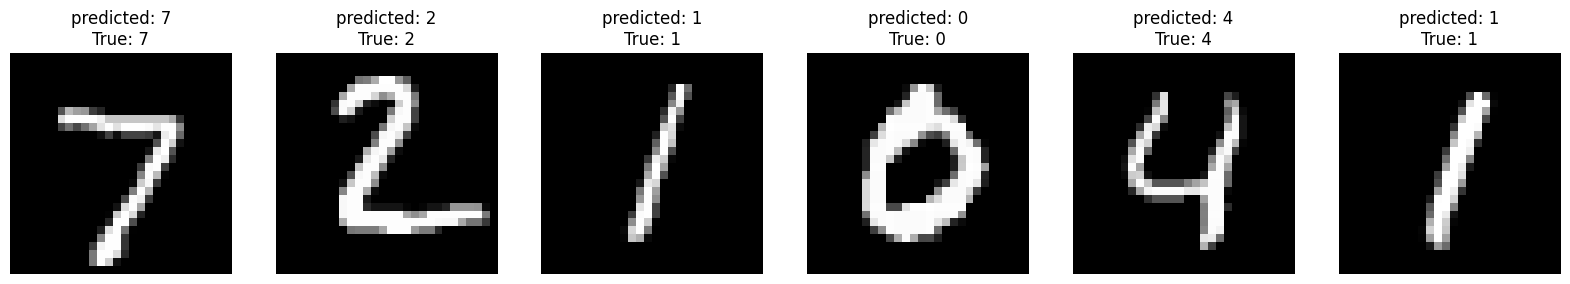

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Usesing the trained model to predict on test images.

decoder_input_data_test = np.full((len(x_test), 1), 10)  # SOS token (index 10)
predictions = model.predict([x_test, decoder_input_data_test])

# Get the predicted token (digit) by taking the argmax over the vocabulary axis.
predicted_tokens = np.argmax(predictions, axis=-1)  # shape: (batch, 1)

# Visualize the predictions for a few test images.
n = 6  # Number of images to display
plt.figure(figsize=(20, 5))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap="gray")

    pred_digit = predicted_tokens[i, 0]
    true_digit = decoder_target_data_test[i, 0]

    plt.title(f"predicted: {pred_digit}\nTrue: {true_digit}")
    plt.axis("off")

plt.show()

In [9]:
model.save("my_model.keras")

In [10]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the saved model
model = tf.keras.models.load_model("/content/my_model.keras")

# File names : Only have files one to five :
number_names = ["zero", "one", "two", "three", "four",
                "five", "six", "seven", "eight", "nine"]

for name in number_names:
    file_path = f"/content/{name}.png"

    # Read the image and convert it to grayscale
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)

    if img is None:
        print(f"Image not found: {file_path}")
        continue

    # Resize to 28x28 (This is the expected input size)
    img_resized = cv2.resize(img, (28, 28))

    # Normalize pixel values
    img_normalized = img_resized.astype("float32") / 255.0

    # Reshape to (1, 28, 28, 1) to match model input shape
    img_input = np.expand_dims(img_normalized, axis=0)  # (1, 28, 28)
    img_input = np.expand_dims(img_input, axis=-1)      # (1, 28, 28, 1)

    # Create the decoder input (SOS token = 10)
    decoder_input = np.array([[10]])  # shape: (1, 1)

    # Predicting using the model
    predictions = model.predict([img_input, decoder_input])
    predicted_token = np.argmax(predictions, axis=-1)[0, 0]
    predicted_name = number_names[predicted_token]

    print(f"Image: {name}.png, Predicted: {predicted_name}")

    # Visualize
    plt.figure(figsize=(3, 3))
    plt.imshow(img_resized, cmap="gray")
    plt.title(f"Predicted: {predicted_name}")
    plt.axis("off")
    plt.show()


Image not found: /content/zero.png
Image not found: /content/one.png
Image not found: /content/two.png
Image not found: /content/three.png
Image not found: /content/four.png
Image not found: /content/five.png
Image not found: /content/six.png
Image not found: /content/seven.png
Image not found: /content/eight.png
Image not found: /content/nine.png
